In [ ]:
from pathlib import Path
import sys, os
project_root = str(Path.cwd().parent.resolve())

from src.dataset import GTSRBDataset

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# --- 1. Configuration ---

BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
SHUFFLE_DATASET = True
RANDOM_SEED = 42

CSV_PATH = '../data/GTSRB/Train.csv' 
ROOT_DIR = '../data/GTSRB'

In [17]:
# --- 2. Define Transformations ---

# Training: Includes Data Augmentation (Rotation, Shift, Color Jitter)
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    # Normalize with standard ImageNet values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation: Clean images (No augmentation, just resizing and normalization)
val_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
# --- 3. Create Datasets and Split ---

# Instantiating dataset once with train_transforms, and once with val_transforms.
train_dataset_full = GTSRBDataset(csv_file=CSV_PATH, root_dir=ROOT_DIR, transform=train_transform)
val_dataset_full   = GTSRBDataset(csv_file=CSV_PATH, root_dir=ROOT_DIR, transform=val_transform)

# Create split indices
dataset_size = len(train_dataset_full)
indices = list(range(dataset_size))
split = int(np.floor(VALIDATION_SPLIT * dataset_size))

if SHUFFLE_DATASET:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Create Samplers
# Samplers tell the DataLoader which indices to pick
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [20]:
# --- 4. Create DataLoaders ---

train_loader = DataLoader(
    train_dataset_full, 
    batch_size=BATCH_SIZE, 
    sampler=train_sampler,
    num_workers=4  
)

val_loader = DataLoader(
    val_dataset_full, 
    batch_size=BATCH_SIZE, 
    sampler=val_sampler,
    num_workers=4  
)

print(f"Total Training Samples: {len(train_indices)}")
print(f"Total Validation Samples: {len(val_indices)}")

Total Training Samples: 31368
Total Validation Samples: 7841


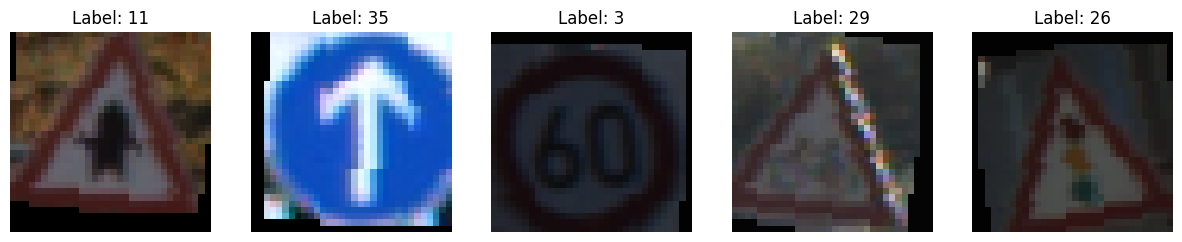

In [21]:
# Function to un-normalize and display an image
def imshow(img):
    # Undo normalization for visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img = img.numpy().transpose((1, 2, 0)) # Convert from Tensor image
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.axis('off')

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the first 5 images in the batch
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(images[i])
    plt.title(f"Label: {labels[i].item()}")
plt.show()